In [1]:
# a. Parse data from files

def read_data(file_name):
    data, label = [], []
    f = open(file_name, 'r')
    for line in f:
        tmp = line.strip().split('\t')
        data.append(tmp[0])
        label.append(int(tmp[1]))
    f.close()
    return data, label

def print_info(labels, dataset_name):
    zeroes, ones = 0, 0
    for ele in labels:
        if ele == 0:
            zeroes += 1
        else:
            ones += 1
    print '{}: There are {} negative labels, {} positive labels.'.format(dataset_name, zeroes, ones),
    print ' It is balanced.' if zeroes == ones \
    else 'It is not balanced. The ratio of positive labels is: %.4f, the ratio of negative labels is: %.4f'\
    % (ones * 1.0 / (zeroes + ones), zeroes * 1.0 / (zeroes + ones))

amazon_data, amazon_label = read_data('amazon_cells_labelled.txt')
imdb_data, imdb_label = read_data('imdb_labelled.txt')
yelp_data, yelp_label = read_data('yelp_labelled.txt')

print_info(amazon_label, 'Amzon Dataset')
print_info(imdb_label, 'IMDB Dataset')
print_info(yelp_label, 'Yelp Dataset')

data = amazon_data + imdb_data + yelp_data
labels = amazon_label + imdb_label + yelp_label

print_info(labels, 'Overall')

Amzon Dataset: There are 500 negative labels, 500 positive labels.  It is balanced.
IMDB Dataset: There are 500 negative labels, 500 positive labels.  It is balanced.
Yelp Dataset: There are 500 negative labels, 500 positive labels.  It is balanced.
Overall: There are 1500 negative labels, 1500 positive labels.  It is balanced.


In [2]:
# b. Preprocessing

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

# lowercase all of the words
for i in range(len(data)):
    data[i] = data[i].lower()

# remove punctuation and strip 
for i in range(len(data)):
    data[i] = data[i].translate(None, string.punctuation)
    data[i] = data[i].strip()

# strip the stop words
for i in range(len(data)):
    words = data[i].split()
    tmp = []
    for word in words:
        if word not in stopwords.words("english"):
            tmp.append(word)
    data[i] = ' '.join(tmp)

# Lemmatization of all the words
port = PorterStemmer()
for i in range(len(data)):
    try:
        data[i] = ' '.join([port.stem(j) for j in data[i].split()])
    except:
        pass

/Users/andywei/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [3]:
# c. split training and testing data

train_data, train_labels = [], []
test_data, test_labels = [], []
for i in range(3):
    start = 1000 * i
    ones, zeroes = 0, 0
    for i in range(start, start + 1000):
        if labels[i] == 1:
            ones += 1
            if ones <= 400:
                train_data.append(data[i])
                train_labels.append(1)
            else:
                test_data.append(data[i])
                test_labels.append(1)
        else:
            zeroes += 1
            if zeroes <= 400:
                train_data.append(data[i])
                train_labels.append(0)
            else:
                test_data.append(data[i])
                test_labels.append(0)
print len(train_data)
print len(train_labels)
print len(test_data)
print len(test_labels)

2400
2400
600
600


In [6]:
# d. Bag of words

import numpy as np
# Build dictionary of unique words in training set
word_set = set()
for s in train_data:
    for w in s.split(' '):
        word_set.add(w)
word_dic = {}
for index, word in enumerate(list(word_set)):
    word_dic[word] = index
# buid feature vectors for training data and test data
train_features, test_features = [], []
count = len(word_dic)
for s in train_data:
    feature = [0] * count
    for w in s.split(' '):
        feature[word_dic[w]] += 1
    train_features.append(feature)
for s in test_data:
    feature = [0] * count
    for w in s.split(' '):
        if w in word_dic:
            feature[word_dic[w]] += 1
    test_features.append(feature)
print len(train_features)
print len(test_features)
train_features = np.array(train_features)
test_features = np.array(test_features)
# report feature vectors of any two reviews in the training set
print train_features[3]
print train_features[4]
print train_data[3]
print train_data[4]

2400
600
[0 0 0 ..., 0 0 0]
[0 0 0 ..., 0 0 0]
tie charger convers last 45 minutesmajor problem
mic great


In [8]:
# e. Postprocessing strategy: using L2 norm

from sklearn import preprocessing

train_post = preprocessing.normalize(train_features, norm='l2')
test_post = preprocessing.normalize(test_features, norm='l2')

/Users/andywei/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


The accuracy of Logistic Regression is: 0.8133
Normalized confusion matrix
[[ 0.84666667  0.15333333]
 [ 0.22        0.78      ]]


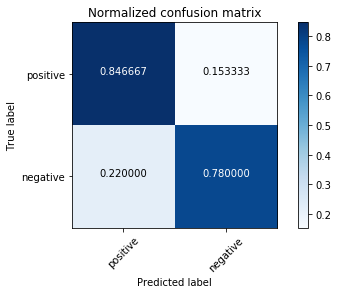

20 significant words in deciding the positive sentiment of the reviews
great
love
excel
nice
delici
amaz
good
best
fantast
beauti
awesom
comfort
well
friendli
wonder
price
perfect
enjoy
cool
fine
20 significant words in deciding the negative sentiment of the reviews
bad  poor  worst  terribl  didnt  disappoint  wast  suck  aw  minut  horribl  stupid  slow  dont  noth  doesnt  never  avoid  plot  bland  The accuracy of BernoulliNB is: 0.8133
Normalized confusion matrix
[[ 0.86        0.14      ]
 [ 0.23333333  0.76666667]]


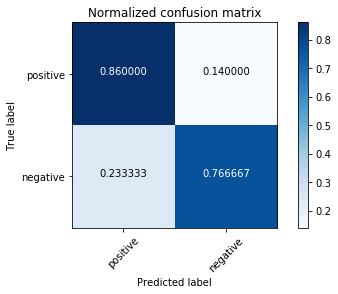

20 significant words in deciding the positive sentiment of the reviews
great
good
film
phone
love
movi
work
one
well
like
best
food
place
realli
time
excel
nice
servic
price
use
20 significant words in deciding the negative sentiment of the reviews
inexperi  heist  010  ticker  ticket  verg  17  mechan  focus  fat  reader  godfath  neglig  sand  yell  humili  sashimi  brokeni  mp3  dollar 


In [10]:
# f. Sentiment Prediction

import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

# See: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.6f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# run classifier
def classify(method, trd, trl, ted, tel, dic):
    if method == 'lr':
        clf = LogisticRegression()
        name = 'Logistic Regression'
    else:
        clf = BernoulliNB()
        name = 'BernoulliNB'
    clf.fit(trd, trl)
    acc = clf.score(ted, tel)
    print 'The accuracy of %s is: %.4f' % (name, acc)
    # print confusion matrix
    y_pred = clf.predict(ted)
    cm = confusion_matrix(tel, y_pred)
    class_names = {"negative", "positive"}
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    # find significant words in deciding the sentiment of the reviews
    coef = clf.coef_[0]
    indices = np.argsort(coef)[::-1]
    if len(dic) != 0:
        print '20 significant words in deciding the positive sentiment of the reviews'
    for i in indices[:20]:
        for w in dic.keys():
            if dic[w] == i:
                print(w)
    if len(dic) != 0:
        print '20 significant words in deciding the negative sentiment of the reviews'
    for i in indices[::-1][:20]:
        for w in dic.keys():
            if dic[w] == i:
                print(w + " "),

classify('lr', train_post, train_labels, test_post, test_labels, word_dic)
classify('nb', train_post, train_labels, test_post, test_labels, word_dic)

The accuracy of Logistic Regression is: 0.6367
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.61  0.39]]


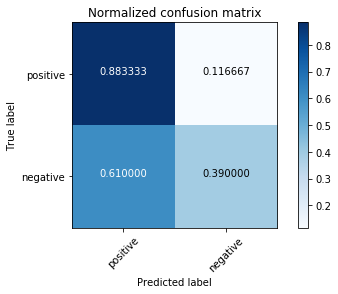

20 significant words in deciding the positive sentiment of the reviews
work great
highli recommend
one best
great phone
great product
food good
easi use
great food
realli good
good price
love place
wont disappoint
great servic
food delici
reason price
love phone
5 star
realli like
worth check
good product
20 significant words in deciding the negative sentiment of the reviews
disappoint
wast time
dont wast
wast money
custom servic
dont buy
wont back
horribl
poor qualiti
piec junk
dont think
stay away
doesnt work
send back
wait wait
realli bad
bad film
dont go
go back
act bad
The accuracy of BernoulliNB is: 0.6367
Normalized confusion matrix
[[ 0.9   0.1 ]
 [ 0.62  0.38]]


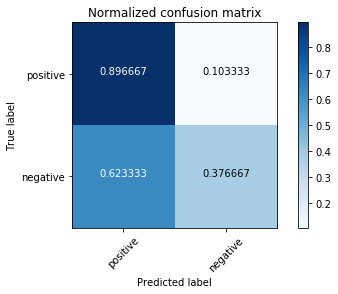

20 significant words in deciding the positive sentiment of the reviews
work great
highli recommend
one best
sound qualiti
work well
great food
great product
great phone
ive ever
food good
film great
realli good
great servic
batteri life
great place
well made
year ago
work fine
realli like
phone work
20 significant words in deciding the negative sentiment of the reviews
burger write
milkshak noth
buyer bewar
lot like
coupl locat
5 drop
budget clearli
receipt luck
dribbl watch
think work
talk one
accident activ
honor pizza
lock everi
lock second
valley refrain
loud buzz
noth authent
would total
get softwar


In [130]:
# g. 2-gram model

def get_2gram(sentence):
    res = []
    words = sentence.split()
    if len(words) < 2:
        return [sentence]
    for t in zip(words, words[1:]):
        res.append(' '.join(t))
    return res

# Build dictionary of unique words in training set
ng_word_set = set()
for s in train_data:
    for w in get_2gram(s):
        ng_word_set.add(w)
ng_word_dic = {}
for index, word in enumerate(list(ng_word_set)):
    ng_word_dic[word] = index
    
# buid feature vectors for training data and test data
ng_train_features, ng_test_features = [], []
count = len(ng_word_dic)
for s in train_data:
    feature = [0] * count
    for w in get_2gram(s):
        feature[ng_word_dic[w]] += 1
    ng_train_features.append(feature)
for s in test_data:
    feature = [0] * count
    for w in get_2gram(s):
        if w in ng_word_dic:
            feature[ng_word_dic[w]] += 1
    ng_test_features.append(feature)
ng_train_features = np.array(ng_train_features)
ng_test_features = np.array(ng_test_features)

# post processing using l2 norm
ng_train_post = preprocessing.normalize(ng_train_features, norm='l2')
ng_test_post = preprocessing.normalize(ng_test_features, norm='l2')

classify('lr', ng_train_post, train_labels, ng_test_post, test_labels, ng_word_dic)
classify('nb', ng_train_post, train_labels, ng_test_post, test_labels, ng_word_dic)

PCA10
The accuracy of Logistic Regression is: 0.4967
Normalized confusion matrix
[[ 0.67        0.33      ]
 [ 0.67666667  0.32333333]]


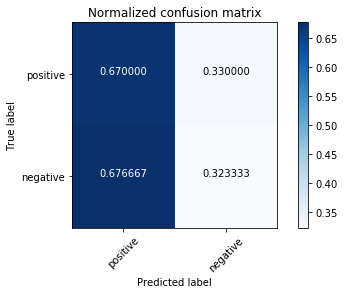

The accuracy of BernoulliNB is: 0.4917
Normalized confusion matrix
[[ 0.35666667  0.64333333]
 [ 0.37333333  0.62666667]]


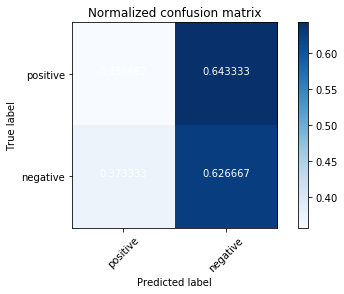

PCA50
The accuracy of Logistic Regression is: 0.5283
Normalized confusion matrix
[[ 0.59666667  0.40333333]
 [ 0.54        0.46      ]]


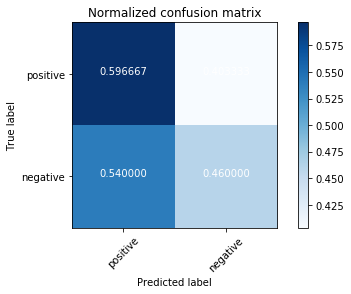

The accuracy of BernoulliNB is: 0.5083
Normalized confusion matrix
[[ 0.29666667  0.70333333]
 [ 0.28        0.72      ]]


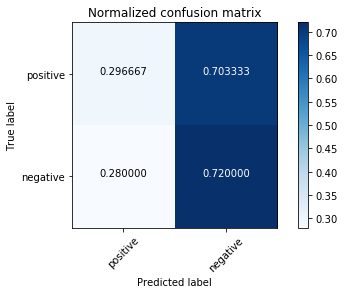

PCA100
The accuracy of Logistic Regression is: 0.5167
Normalized confusion matrix
[[ 0.53666667  0.46333333]
 [ 0.50333333  0.49666667]]


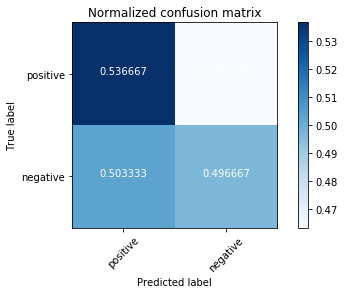

The accuracy of BernoulliNB is: 0.5167
Normalized confusion matrix
[[ 0.30333333  0.69666667]
 [ 0.27        0.73      ]]


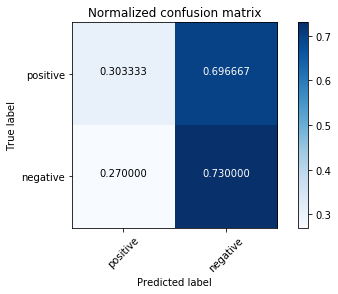

In [12]:
# h. PCA
from numpy.linalg import svd

def PCA(X, n):
    X -= np.mean(X, axis=0)
    V = svd(X)[-1]
    return X.dot(V[:n, :].T)

train_pca10 = PCA(train_post, 10)
test_pca10 = PCA(test_post, 10)
train_pca50 = PCA(train_post, 50)
test_pca50 = PCA(test_post, 50)
train_pca100 = PCA(train_post, 100)
test_pca100 = PCA(test_post, 100)
print 'PCA10'
classify('lr', train_pca10, train_labels, test_pca10, test_labels, {})
classify('nb', train_pca10, train_labels, test_pca10, test_labels, {})
print 'PCA50'
classify('lr', train_pca50, train_labels, test_pca50, test_labels, {})
classify('nb', train_pca50, train_labels, test_pca50, test_labels, {})
print 'PCA100'
classify('lr', train_pca100, train_labels, test_pca100, test_labels, {})
classify('nb', train_pca100, train_labels, test_pca100, test_labels, {})